# 频繁模式与关联规则挖掘
选用数据集：
1. Microsoft 资讯推荐:  https://learn.microsoft.com/zh-cn/azure/open-datasets/dataset-microsoft-news?tabs=azureml-opendatasets
2. DBLP: https://dblp.uni-trier.de/xml/

## download dataset

In [1]:
import os
import tempfile
import urllib
import zipfile
import pandas as pd

# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
temp_dir = os.path.join(tempfile.gettempdir(), 'mind')
os.makedirs(temp_dir, exist_ok=True)

# The dataset is split into training and validation set, each with a large and small version.
# The format of the four files are the same.
# For demonstration purpose, we will use small version validation set only.
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

In [2]:
def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

### 下载并提取数据集

In [3]:
# For demonstration purpose, we will use small version validation set only.
# This file is about 30MB.
zip_path = download_url(validation_small_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

['behaviors.tsv',
 'entity_embedding.vec',
 'https_mind201910small.blob.core.windows.net_release_MINDsmall_dev.zip',
 'news.tsv',
 'relation_embedding.vec']

### 使用pandas 读取数据

In [4]:
# The behaviors.tsv file contains the impression logs and users' news click histories. 
# It has 5 columns divided by the tab symbol:
# - Impression ID. The ID of an impression.
# - User ID. The anonymous ID of a user.
# - Time. The impression time with format "MM/DD/YYYY HH:MM:SS AM/PM".
# - History. The news click history (ID list of clicked news) of this user before this impression.
# - Impressions. List of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click).
behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

,impression_id,user_id,time,history,impressions
0,1,U80234,11/15/2019 12:37:50 PM,N55189 N46039 N51741 N53234 N11276 N264 N40716...,N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...
1,2,U60458,11/15/2019 7:11:50 AM,N58715 N32109 N51180 N33438 N54827 N28488 N611...,N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...
2,3,U44190,11/15/2019 9:55:12 AM,N56253 N1150 N55189 N16233 N61704 N51706 N5303...,N36779-0 N62365-0 N58098-0 N5472-0 N13408-0 N5...
3,4,U87380,11/15/2019 3:12:46 PM,N63554 N49153 N28678 N23232 N43369 N58518 N444...,N6950-0 N60215-0 N6074-0 N11930-0 N6916-0 N248...
4,5,U9444,11/15/2019 8:25:46 AM,N51692 N18285 N26015 N22679 N55556,N5940-1 N23513-0 N49285-0 N23355-0 N19990-0 N3...
...,...,...,...,...,...
73147,73148,U77536,11/15/2019 8:40:16 PM,N28691 N8845 N58434 N37120 N22185 N60033 N4702...,N496-0 N35159-0 N59856-0 N13270-0 N47213-0 N26...
73148,73149,U56193,11/15/2019 1:11:26 PM,N4705 N58782 N53531 N46492 N26026 N28088 N3109...,N49285-0 N31958-0 N55237-0 N42844-0 N29862-0 N...
73149,73150,U16799,11/15/2019 3:37:06 PM,N40826 N42078 N15670 N15295 N64536 N46845 N52294,N7043-0 N512-0 N60215-1 N45057-0 N496-0 N37055...
73150,73151,U8786,11/15/2019 8:29:26 AM,N3046 N356 N20483 N46107 N44598 N18693 N8254 N...,N23692-0 N19990-0 N20187-0 N5940-0 N13408-0 N3...


In [5]:
# The news.tsv file contains the detailed information of news articles involved in the behaviors.tsv file.
# It has 7 columns, which are divided by the tab symbol:
# - News ID
# - Category
# - Subcategory
# - Title
# - Abstract
# - URL
# - Title Entities (entities contained in the title of this news)
# - Abstract Entities (entities contained in the abstract of this news)
news_path = os.path.join(temp_dir, 'news.tsv')
pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N18955,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
...,...,...,...,...,...,...,...,...
42411,N63550,lifestyle,lifestyleroyals,Why Kate & Meghan Were on Different Balconies ...,There's no scandal here. It's all about the or...,https://assets.msn.com/labs/mind/BBWyynu.html,"[{""Label"": ""Meghan, Duchess of Sussex"", ""Type""...",[]
42412,N30345,entertainment,entertainment-celebrity,See the stars at the 2019 Baby2Baby gala,Stars like Chrissy Teigen and Kate Hudson supp...,https://assets.msn.com/labs/mind/BBWyz7N.html,[],"[{""Label"": ""Kate Hudson"", ""Type"": ""P"", ""Wikida..."
42413,N30135,news,newsgoodnews,Tennessee judge holds lawyer's baby as he swea...,Tennessee Court of Appeals Judge Richard Dinki...,https://assets.msn.com/labs/mind/BBWyzI8.html,"[{""Label"": ""Tennessee"", ""Type"": ""G"", ""Wikidata...","[{""Label"": ""Tennessee Court of Appeals"", ""Type..."
42414,N44276,autos,autossports,Best Sports Car Deals for October,NaN,https://assets.msn.com/labs/mind/BBy5rVe.html,"[{""Label"": ""Peugeot RCZ"", ""Type"": ""V"", ""Wikida...",[]


In [6]:
# The entity_embedding.vec file contains the 100-dimensional embeddings
# of the entities learned from the subgraph by TransE method.
# The first column is the ID of entity, and the other columns are the embedding vector values.
entity_embedding_path = os.path.join(temp_dir, 'entity_embedding.vec')
entity_embedding = pd.read_table(entity_embedding_path, header=None)
entity_embedding['vector'] = entity_embedding.iloc[:, 1:101].values.tolist()
entity_embedding = entity_embedding[[0,
                                     'vector']].rename(columns={0: "entity"})
entity_embedding


,entity,vector
0,Q34433,"[0.017808, -0.073256, 0.102521, -0.059926, -0...."
1,Q41,"[-0.063388, -0.181451, 0.057501, -0.091254, -0..."
2,Q56037,"[0.02155, -0.044888, -0.027872, -0.128843, 0.0..."
3,Q1860,"[0.060958, 0.069934, 0.015832, 0.079471, -0.02..."
4,Q39631,"[-0.093106, -0.052002, 0.020556, -0.020801, 0...."
...,...,...
22888,Q278846,"[0.042413, 0.021957, 0.072414, -0.068437, 0.02..."
22889,Q54621949,"[-0.018299, -0.048378, -0.021645, -0.079743, 0..."
22890,Q42225228,"[-0.051346, -0.028947, -0.07587, 0.017512, -0...."
22891,Q54862508,"[-0.052323, -0.078029, -0.060925, -0.052536, 0..."


In [7]:
# The relation_embedding.vec file contains the 100-dimensional embeddings
# of the relations learned from the subgraph by TransE method.
# The first column is the ID of relation, and the other columns are the embedding vector values.
relation_embedding_path = os.path.join(temp_dir, 'relation_embedding.vec')
relation_embedding = pd.read_table(relation_embedding_path, header=None)
relation_embedding['vector'] = relation_embedding.iloc[:,
                                                       1:101].values.tolist()
relation_embedding = relation_embedding[[0, 'vector'
                                         ]].rename(columns={0: "relation"})
relation_embedding

,relation,vector
0,P31,"[-0.073467, -0.132227, 0.034173, -0.032769, 0...."
1,P21,"[-0.078436, 0.108589, -0.049429, -0.131355, 0...."
2,P106,"[-0.052137, 0.052444, -0.019886, -0.152309, 0...."
3,P735,"[-0.051398, 0.056219, 0.068029, -0.137717, -0...."
4,P108,"[0.091231, 0.022526, 0.059349, -0.141853, 0.03..."
...,...,...
1086,P1897,"[-0.019021, 0.001183, -0.009602, -0.040833, -0..."
1087,P3776,"[-0.018365, 0.028526, -0.025934, 0.032296, -0...."
1088,P1194,"[-0.026819, 0.003231, -0.011298, -0.015206, 0...."
1089,P2502,"[0.003554, -0.041121, -0.010559, -0.037862, -0..."


## 数据预处理
- 确定挖掘目标
- 构建合适项集

In [54]:
import pandas as pd
import os

# Assuming `temp_dir` contains the path to the directory where the TSV files are located.

behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
behaviors_df = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

news_path = os.path.join(temp_dir, 'news.tsv')
news_df = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])

### 探索性数据分析

In [47]:
# 统计各类型新闻个数
category_counts = news_df['category'].value_counts()
category_counts

category
news             13043
sports           11760
finance           2563
foodanddrink      2248
lifestyle         2132
travel            1845
health            1715
video             1600
autos             1490
weather           1462
tv                 822
music              625
entertainment      559
movies             538
kids                11
middleeast           2
games                1
Name: count, dtype: int64

In [16]:
subcategory_counts = news_df['subcategory'].value_counts()
print(subcategory_counts)

subcategory
newsus                         5335
football_nfl                   4747
newspolitics                   2398
newscrime                      1797
newsworld                      1525
                               ... 
othersports                       1
newsrealestate                    1
lifestyleshoppinghomegarden       1
comedy                            1
celebhub                          1
Name: count, Length: 257, dtype: int64


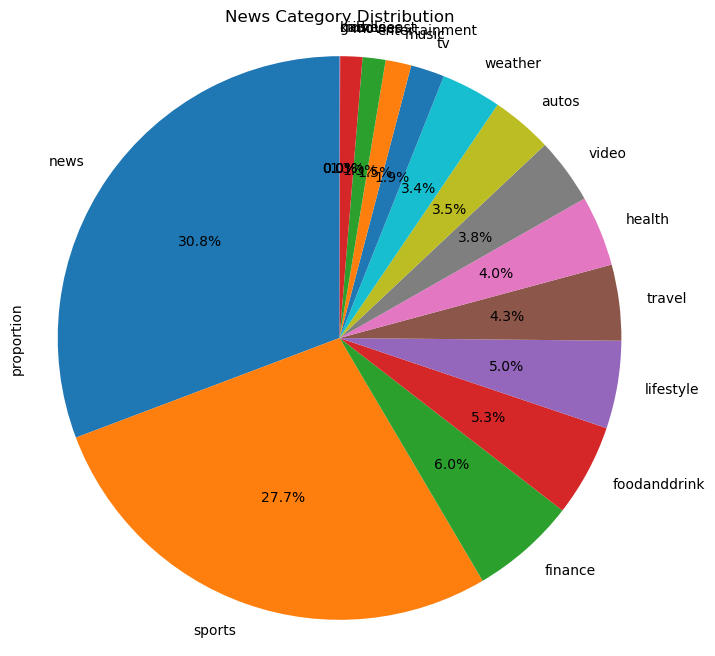

In [119]:
import matplotlib.pyplot as plt

# 统计 category 列的计数
category_counts = news_df['category'].value_counts(normalize=True)  # 使用 normalize=True 得到百分比

# 绘制饼图
plt.figure(figsize=(8, 8))
category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('News Category Distribution')
plt.axis('equal')  # 使饼图保持圆形
plt.show()

In [60]:
def split_string(s):
    if pd.isna(s):  # 或者使用 if s is None:  如果您的空值表现为None而非NaN
        return []
    else:
        return [item.strip() for item in s.split(' ')]

In [56]:

behaviors_df['impressions'] = behaviors_df['impressions'].apply(split_string)

In [61]:
print(behaviors_df.head())

   impression_id user_id                    time  \
0              1  U80234  11/15/2019 12:37:50 PM   
1              2  U60458   11/15/2019 7:11:50 AM   
2              3  U44190   11/15/2019 9:55:12 AM   
3              4  U87380   11/15/2019 3:12:46 PM   
4              5   U9444   11/15/2019 8:25:46 AM   

                                             history  \
0  N55189 N46039 N51741 N53234 N11276 N264 N40716...   
1  N58715 N32109 N51180 N33438 N54827 N28488 N611...   
2  N56253 N1150 N55189 N16233 N61704 N51706 N5303...   
3  N63554 N49153 N28678 N23232 N43369 N58518 N444...   
4                 N51692 N18285 N26015 N22679 N55556   

                                         impressions  
0  [N28682-0, N48740-0, N31958-1, N34130-0, N6916...  
1  [N20036-0, N23513-1, N32536-0, N46976-0, N3521...  
2  [N36779-0, N62365-0, N58098-0, N5472-0, N13408...  
3  [N6950-0, N60215-0, N6074-0, N11930-0, N6916-0...  
4  [N5940-1, N23513-0, N49285-0, N23355-0, N19990...  


In [58]:
# 检查'history'列空值
print(behaviors_df['history'].isnull().sum())

2214


In [62]:
behaviors_df['history'] = behaviors_df['history'].apply(split_string)

In [65]:
print(behaviors_df)

       impression_id user_id                    time  \
0                  1  U80234  11/15/2019 12:37:50 PM   
1                  2  U60458   11/15/2019 7:11:50 AM   
2                  3  U44190   11/15/2019 9:55:12 AM   
3                  4  U87380   11/15/2019 3:12:46 PM   
4                  5   U9444   11/15/2019 8:25:46 AM   
...              ...     ...                     ...   
73147          73148  U77536   11/15/2019 8:40:16 PM   
73148          73149  U56193   11/15/2019 1:11:26 PM   
73149          73150  U16799   11/15/2019 3:37:06 PM   
73150          73151   U8786   11/15/2019 8:29:26 AM   
73151          73152  U68182  11/15/2019 11:54:34 AM   

                                                 history  \
0      [N55189, N46039, N51741, N53234, N11276, N264,...   
1      [N58715, N32109, N51180, N33438, N54827, N2848...   
2      [N56253, N1150, N55189, N16233, N61704, N51706...   
3      [N63554, N49153, N28678, N23232, N43369, N5851...   
4               [N51692, N1

### 转换项集
整理impressions和history中的点击和未点击作为输入项集

In [80]:
behaviors_df

,impression_id,user_id,time,history,impressions,clicked_news,unclicked_news
0,1,U80234,11/15/2019 12:37:50 PM,"[N55189, N46039, N51741, N53234, N11276, N264,...","[N28682-0, N48740-0, N31958-1, N34130-0, N6916...",[N31958],"[N28682, N48740, N34130, N6916, N5472, N50775,..."
1,2,U60458,11/15/2019 7:11:50 AM,"[N58715, N32109, N51180, N33438, N54827, N2848...","[N20036-0, N23513-1, N32536-0, N46976-0, N3521...",[N23513],"[N20036, N32536, N46976, N35216, N36779, N31958]"
2,3,U44190,11/15/2019 9:55:12 AM,"[N56253, N1150, N55189, N16233, N61704, N51706...","[N36779-0, N62365-0, N58098-0, N5472-0, N13408...",[N5940],"[N36779, N62365, N58098, N5472, N13408, N55036..."
3,4,U87380,11/15/2019 3:12:46 PM,"[N63554, N49153, N28678, N23232, N43369, N5851...","[N6950-0, N60215-0, N6074-0, N11930-0, N6916-0...",[N15347],"[N6950, N60215, N6074, N11930, N6916, N24802, ..."
4,5,U9444,11/15/2019 8:25:46 AM,"[N51692, N18285, N26015, N22679, N55556]","[N5940-1, N23513-0, N49285-0, N23355-0, N19990...","[N5940, N31958]","[N23513, N49285, N23355, N19990, N29393, N3029..."
...,...,...,...,...,...,...,...
73147,73148,U77536,11/15/2019 8:40:16 PM,"[N28691, N8845, N58434, N37120, N22185, N60033...","[N496-0, N35159-0, N59856-0, N13270-0, N47213-...","[N38324, N6916, N56080, N54562, N13573, N60244...","[N496, N35159, N59856, N13270, N47213, N26485,..."
73148,73149,U56193,11/15/2019 1:11:26 PM,"[N4705, N58782, N53531, N46492, N26026, N28088...","[N49285-0, N31958-0, N55237-0, N42844-0, N2986...",[N11390],"[N49285, N31958, N55237, N42844, N29862, N1999..."
73149,73150,U16799,11/15/2019 3:37:06 PM,"[N40826, N42078, N15670, N15295, N64536, N4684...","[N7043-0, N512-0, N60215-1, N45057-0, N496-0, ...","[N60215, N54562]","[N7043, N512, N45057, N496, N37055, N16344, N5..."
73150,73151,U8786,11/15/2019 8:29:26 AM,"[N3046, N356, N20483, N46107, N44598, N18693, ...","[N23692-0, N19990-0, N20187-0, N5940-0, N13408...",[N20036],"[N23692, N19990, N20187, N5940, N13408, N31958..."


In [121]:
def separate_clicked_and_unclicked(s):
    clicked_news = []
    unclicked_news = []   

    clicked_categories = []
    unclicked_categories = []   
    
    for item in s:
        news_id, click_status = item.split('-')
        news_category = news_df.loc[news_id, 'category']
        if click_status == '1':
            clicked_news.append(news_id)
            clicked_categories.append(news_category)
        elif click_status == '0':
            unclicked_news.append(news_id)
            unclicked_categories.append(news_category)
        else :
            print("Invalid click status {click_status} for news {news_id}")

    return clicked_news, unclicked_news, clicked_categories, unclicked_categories

def news_to_category(s):
    news_categories = []
    
    for news_id in s:
        news_category = news_df.loc[news_id, 'category']
        news_categories.append(news_category)
    
    return news_categories


In [93]:
news_df.set_index('id', inplace=True)

# 应用辅助函数到'impressions'列，将点击和未点击新闻分开
clicked_news, unclicked_news, clicked_categories, unclicked_categories = zip(*behaviors_df['impressions'].apply(separate_clicked_and_unclicked))

# 将结果添加为新列到 behaviors_df
behaviors_df['clicked_news'] = clicked_news
behaviors_df['unclicked_news'] = unclicked_news
behaviors_df['clicked_categories'] = clicked_categories
behaviors_df['unclicked_categories'] = unclicked_categories

# 查看结果
print(behaviors_df.head())

   impression_id user_id                    time  \
0              1  U80234  11/15/2019 12:37:50 PM   
1              2  U60458   11/15/2019 7:11:50 AM   
2              3  U44190   11/15/2019 9:55:12 AM   
3              4  U87380   11/15/2019 3:12:46 PM   
4              5   U9444   11/15/2019 8:25:46 AM   

                                             history  \
0  [N55189, N46039, N51741, N53234, N11276, N264,...   
1  [N58715, N32109, N51180, N33438, N54827, N2848...   
2  [N56253, N1150, N55189, N16233, N61704, N51706...   
3  [N63554, N49153, N28678, N23232, N43369, N5851...   
4           [N51692, N18285, N26015, N22679, N55556]   

                                         impressions     clicked_news  \
0  [N28682-0, N48740-0, N31958-1, N34130-0, N6916...         [N31958]   
1  [N20036-0, N23513-1, N32536-0, N46976-0, N3521...         [N23513]   
2  [N36779-0, N62365-0, N58098-0, N5472-0, N13408...          [N5940]   
3  [N6950-0, N60215-0, N6074-0, N11930-0, N6916-0...      

In [95]:
print(behaviors_df['clicked_categories'].head(20))

0                  [sports]
1                  [sports]
2               [lifestyle]
3                  [sports]
4       [lifestyle, sports]
5            [news, sports]
6                  [health]
7          [sports, sports]
8                    [news]
9              [news, news]
10           [news, sports]
11    [news, weather, news]
12                 [sports]
13                  [music]
14                 [sports]
15       [finance, finance]
16                 [sports]
17                  [video]
18                 [sports]
19                 [sports]
Name: clicked_categories, dtype: object


In [126]:
history_news_categories = behaviors_df['history'].apply(news_to_category)
behaviors_df['history_categories'] = history_news_categories


In [127]:

print(behaviors_df['history_categories'].head())

0    [tv, news, tv, news, finance, autos, tv, movie...
1    [news, travel, finance, news, news, finance, m...
2    [sports, news, tv, news, lifestyle, sports, ne...
3    [travel, news, sports, sports, travel, news, t...
4         [tv, sports, entertainment, sports, finance]
Name: history_categories, dtype: object


### 频繁模式挖掘
主要分析不同类型的新闻的关联性。

- 对点击行为的挖掘
- 对不点击的新闻类型进行挖掘分析

In [103]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


In [134]:
def mining(df=behaviors_df['clicked_categories'], min_support=0.5, min_confidence=0.1):
    df = df.dropna()
    # 将 clicked_categories 列转换为 TransactionEncoder 可处理的二维列表形式
    transactions = df.tolist()

    # 创建 TransactionEncoder 对象并编码数据
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)

    # 用编码后的数据创建一个 DataFrame
    df = pd.DataFrame(te_ary, columns=te.columns_)

    # 设置最小支持度阈值（例如 0.1 表示至少 10% 的事务中包含该模式）
    # min_support = 0.5

    # 使用 Apriori 算法找出频繁项集
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)


    # 按照支持度（'support'属性）降序排列频繁项集
    frequent_itemsets.sort_values(by='support', ascending=False, inplace=True)


    # 输出频繁项集
    print("Frequent Itemsets:")
    print(frequent_itemsets)

    # 计算关联规则，设置最小置信度阈值（例如 0.¼ 表示规则的预测部分在前提部分出现的情况下至少有 75% 的概率发生）
    # min_confidence = 0.01

    # 计算关联规则
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

    rules.sort_values(by=['confidence'], ascending=False, inplace=True)

    # 输出关联规则
    print("\nAssociation Rules:")
    print(rules)

    return rules

In [116]:
rules_unclicked_categories = mining(behaviors_df['unclicked_categories'])
rules_unclicked_categories.head(10)

Frequent Itemsets:
      support                                           itemsets
0    0.551988                                    (entertainment)
1    0.689769                                          (finance)
2    0.726187                                     (foodanddrink)
3    0.511797                                           (health)
4    0.916653                                        (lifestyle)
..        ...                                                ...
211  0.520068  (foodanddrink, sports, music, lifestyle, finan...
212  0.515119  (foodanddrink, sports, lifestyle, tv, finance,...
213  0.504935  (foodanddrink, sports, music, lifestyle, movie...
214  0.504074  (foodanddrink, sports, lifestyle, tv, movies, ...
215  0.516719  (foodanddrink, sports, music, lifestyle, tv, n...

[216 rows x 2 columns]

Association Rules:
          antecedents                                     consequents  \
0           (finance)                                 (entertainment)   
1     (ente

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(finance),(entertainment),0.689769,0.551988,0.521982,0.756748,1.370951,0.141238,1.841764,0.872188
1,(entertainment),(finance),0.551988,0.689769,0.521982,0.945640,1.370951,0.141238,5.706974,0.603955
2,(foodanddrink),(entertainment),0.726187,0.551988,0.533273,0.734347,1.330369,0.132427,1.686459,0.906928
3,(entertainment),(foodanddrink),0.551988,0.726187,0.533273,0.966096,1.330369,0.132427,8.076196,0.554290
4,(lifestyle),(entertainment),0.916653,0.551988,0.549390,0.599344,1.085792,0.043409,1.118197,0.948005
5,(entertainment),(lifestyle),0.551988,0.916653,0.549390,0.995295,1.085792,0.043409,17.712993,0.176364
6,(music),(entertainment),0.707869,0.551988,0.510102,0.720617,1.305495,0.119368,1.603579,0.801034
7,(entertainment),(music),0.551988,0.707869,0.510102,0.924119,1.305495,0.119368,3.849862,0.522323
8,(news),(entertainment),0.922408,0.551988,0.547258,0.593292,1.074829,0.038100,1.101559,0.897254
9,(entertainment),(news),0.551988,0.922408,0.547258,0.991431,1.074829,0.038100,9.055150,0.155397


In [118]:
# 对点击的行为进行挖掘，探究不同类型的新闻间的潜在关联性
mining(df=behaviors_df['clicked_categories'],min_support=0.01)

Frequent Itemsets:
     support                   itemsets
0   0.036595                    (autos)
1   0.037101            (entertainment)
2   0.051796                  (finance)
3   0.084618             (foodanddrink)
4   0.056280                   (health)
5   0.234061                (lifestyle)
6   0.045125                   (movies)
7   0.050853                    (music)
8   0.298228                     (news)
9   0.309137                   (sports)
10  0.033314                   (travel)
11  0.073559                       (tv)
12  0.035734                    (video)
13  0.022528                  (weather)
14  0.012317            (finance, news)
15  0.016267  (lifestyle, foodanddrink)
16  0.013889       (foodanddrink, news)
17  0.015174     (foodanddrink, sports)
18  0.013547        (lifestyle, health)
19  0.013903             (health, news)
20  0.010745           (health, sports)
21  0.035761          (lifestyle, news)
22  0.033041        (lifestyle, sports)
23  0.012973         

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(finance),(news),0.051796,0.298228,0.012317,0.237794,0.797354,-0.003130,0.920711,-0.211376
1,(foodanddrink),(lifestyle),0.084618,0.234061,0.016267,0.192246,0.821350,-0.003538,0.948233,-0.191994
2,(foodanddrink),(news),0.084618,0.298228,0.013889,0.164136,0.550369,-0.011347,0.839576,-0.471594
3,(foodanddrink),(sports),0.084618,0.309137,0.015174,0.179321,0.580071,-0.010985,0.841819,-0.441605
4,(health),(lifestyle),0.056280,0.234061,0.013547,0.240709,1.028406,0.000374,1.008756,0.029268
5,(health),(news),0.056280,0.298228,0.013903,0.247025,0.828307,-0.002882,0.931998,-0.180089
6,(health),(sports),0.056280,0.309137,0.010745,0.190916,0.617576,-0.006654,0.853882,-0.396195
7,(lifestyle),(news),0.234061,0.298228,0.035761,0.152786,0.512312,-0.034042,0.828329,-0.554136
8,(news),(lifestyle),0.298228,0.234061,0.035761,0.119912,0.512312,-0.034042,0.870299,-0.575638
9,(lifestyle),(sports),0.234061,0.309137,0.033041,0.141163,0.456637,-0.039316,0.804417,-0.608388


各项的置信度都极低，不超过25%，提升度也基本不超过1，说明用户在一个impression中，点击不同类型的新闻的概率极低，更倾向于浏览同一类型的新闻。
因此，在新闻推荐中，应该对尽量为用户推荐同一大类的新闻，而不是推荐不同类型的新闻。

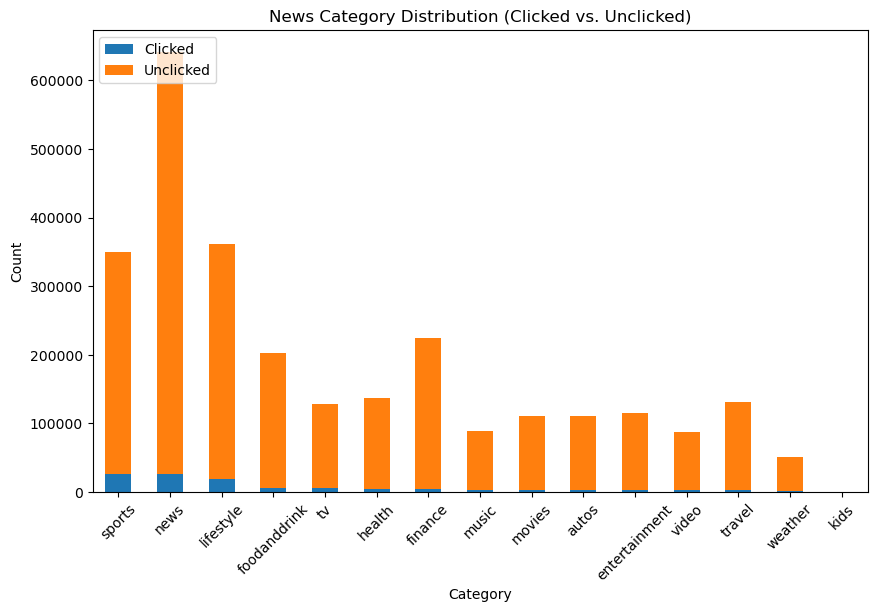

In [120]:
# 统计点击与未点击新闻的类别计数
clicked_counts = behaviors_df['clicked_categories'].explode().value_counts()
unclicked_counts = behaviors_df['unclicked_categories'].explode().value_counts()

# 合并点击与未点击新闻的计数
category_counts = pd.concat([clicked_counts, unclicked_counts], axis=1, keys=['Clicked', 'Unclicked']).fillna(0)

# 绘制堆叠柱状图
category_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('News Category Distribution (Clicked vs. Unclicked)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)  # 旋转x轴标签以便阅读
plt.legend(loc='upper left')
plt.show()

In [137]:
history_rules = mining(df=behaviors_df['history_categories'], min_support=0.2,min_confidence=0.5)

Frequent Itemsets:
      support                                   itemsets
8    0.865814                                     (news)
5    0.692544                                (lifestyle)
9    0.668963                                   (sports)
11   0.644603                                       (tv)
60   0.641213                          (lifestyle, news)
..        ...                                        ...
78   0.200541                            (weather, news)
390  0.200350        (travel, lifestyle, health, sports)
438  0.200350  (sports, entertainment, tv, movies, news)
127  0.200131         (travel, lifestyle, entertainment)
96   0.200063                    (autos, health, sports)

[513 rows x 2 columns]

Association Rules:
                                            antecedents  \
3845           (travel, sports, lifestyle, tv, finance)   
4156            (sports, music, lifestyle, tv, finance)   
2732                      (travel, tv, finance, sports)   
4483  (foodanddri

In [141]:
history_rules.sort_values(by='confidence', ascending=False, inplace=True)
history_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3845,"(travel, sports, lifestyle, tv, finance)",(news),0.206543,0.865814,0.205244,0.993712,1.147721,0.026417,21.341280,0.162212
4156,"(sports, music, lifestyle, tv, finance)",(news),0.204752,0.865814,0.203193,0.992389,1.146192,0.025916,17.630203,0.160385
2732,"(travel, tv, finance, sports)",(news),0.221306,0.865814,0.219598,0.992279,1.146065,0.027988,17.378743,0.163670
4483,"(foodanddrink, sports, lifestyle, health, fina...",(news),0.202524,0.865814,0.200815,0.991563,1.145238,0.025467,15.903766,0.159025
4283,"(foodanddrink, sports, lifestyle, tv, movies)",(news),0.204342,0.865814,0.202578,0.991370,1.145016,0.025656,15.548974,0.159176
2132,"(foodanddrink, sports, lifestyle, tv, finance)",(news),0.233145,0.865814,0.231122,0.991322,1.144960,0.029262,15.463164,0.165099
3908,"(foodanddrink, lifestyle, tv, movies, finance)",(news),0.206830,0.865814,0.204970,0.991011,1.144601,0.025895,14.928232,0.159276
2043,"(sports, lifestyle, tv, movies, finance)",(news),0.234730,0.865814,0.232612,0.990973,1.144557,0.029379,14.865251,0.165039
3804,"(movies, foodanddrink, sports, finance)",(news),0.207472,0.865814,0.205572,0.990841,1.144405,0.025940,14.651412,0.159216
2321,"(sports, lifestyle, health, tv, finance)",(news),0.228975,0.865814,0.226870,0.990806,1.144364,0.028620,14.594944,0.163616


In [140]:
history_rules.sort_values(by=['lift'], ascending=False, inplace=True)
history_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3937,"(movies, foodanddrink, news)","(lifestyle, finance, tv)",0.282439,0.386346,0.204970,0.725715,1.878406,0.095851,2.237286,0.651699
3940,"(lifestyle, finance, tv)","(movies, foodanddrink, news)",0.386346,0.282439,0.204970,0.530536,1.878406,0.095851,1.528467,0.762048
3926,"(lifestyle, finance, news, tv)","(movies, foodanddrink)",0.377160,0.289575,0.204970,0.543458,1.876742,0.095754,1.556099,0.750051
3948,"(movies, foodanddrink)","(lifestyle, finance, news, tv)",0.289575,0.377160,0.204970,0.707832,1.876742,0.095754,2.131786,0.657581
4377,"(tv, news, entertainment)","(lifestyle, music)",0.319868,0.338323,0.201512,0.629984,1.862079,0.093293,1.788240,0.680700
4385,"(lifestyle, music)","(tv, news, entertainment)",0.338323,0.319868,0.201512,0.595620,1.862079,0.093293,1.681913,0.699686
4138,"(lifestyle, finance, tv)","(movies, health, news)",0.386346,0.283410,0.203207,0.525971,1.855868,0.093713,1.511702,0.751513
4145,"(movies, health, news)","(lifestyle, finance, tv)",0.283410,0.386346,0.203207,0.717008,1.855868,0.093713,2.168446,0.643560
3941,"(movies, lifestyle, finance)","(tv, foodanddrink, news)",0.308440,0.358158,0.204970,0.664539,1.855434,0.094500,1.913314,0.666670
3935,"(tv, foodanddrink, news)","(movies, lifestyle, finance)",0.358158,0.308440,0.204970,0.572290,1.855434,0.094500,1.616890,0.718312


分别以置信度、提升度进行排序，可以看出不同类别的新闻间的关联性。
